In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import date

In [2]:
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.stats.multicomp

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scikit_posthocs as sp

In [3]:
save = True
only_controlled_random = True #whether to include only 1 out of the 3 random sentence shuffling conditions
# includes the random sentence shuffling ensuring a pick from a different topic & length-match

In [4]:
import warnings; warnings.simplefilter('ignore')

In [5]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.score"

In [6]:
categories_perturb_loss = ['original',
                           'nouns',
                           'nounsverbs',
                           'nounsverbsadj',
                           'contentwords',
                           'random-nouns',
                           'functionwords']

categories_perturb_meaning = ['sentenceshuffle_passage',
                              'sentenceshuffle_topic',
                              'sentenceshuffle_random',
                              'sentenceshuffle_random-topic-criteria',
                              'sentenceshuffle_random-topic-length-criteria']

categories_scrambled = ['original',
                        'scrambled1',
                        'scrambled3',
                        'scrambled5',
                        'scrambled7',
                        'lowpmi',
                        'lowpmi-random',
                        'backward',
                        'random-wl',
                        'random-wl-samepos']

categories_perturb = categories_perturb_loss + categories_perturb_meaning

categories = [categories_perturb, categories_scrambled]
keys = ["perturb", "scrambled"]

categories_dict = dict(zip(keys, categories))

In [7]:
categories_dict

{'perturb': ['original',
  'nouns',
  'nounsverbs',
  'nounsverbsadj',
  'contentwords',
  'random-nouns',
  'functionwords',
  'sentenceshuffle_passage',
  'sentenceshuffle_topic',
  'sentenceshuffle_random',
  'sentenceshuffle_random-topic-criteria',
  'sentenceshuffle_random-topic-length-criteria'],
 'scrambled': ['original',
  'scrambled1',
  'scrambled3',
  'scrambled5',
  'scrambled7',
  'lowpmi',
  'lowpmi-random',
  'backward',
  'random-wl',
  'random-wl-samepos']}

In [8]:
def get_all_layers(model_identifier):
    """
    input: model_identifier of model of which we want to find the layers
    output: np.array of all unique layer identifiers, ordered by position
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        if "model=" + model_identifier in filename:
            file = os.path.join(working_dir,filename)
            with open(file, 'rb') as f:
                result = pickle.load(f)
            result = result['data']
            layer_list = np.unique(result.layer)
            #print(layer_list)
            #order double-digit layers at end of list
            double_digits = []
            if model_identifier in ['gpt2','distilgpt2']:
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
            if model_identifier == 'albert-xxlarge-v2':
                double_digits = [elm for elm in layer_list if 'encoder.albert_layer_groups.' in elm and len(elm.split('.albert_layer_groups.')[-1]) > 1]
            if model_identifier == 'xlnet-large-cased':
                double_digits = [elm for elm in layer_list if 'encoder.layer.' in elm and len(elm.split('.layer.')[-1]) > 1]
            if model_identifier == 'bert-large-uncased-whole-word-masking':
                double_digits = [elm for elm in layer_list if '.layer.' in elm and len(elm.split('.layer.')[-1].split('.')[0]) > 1]
            layers = [e for e in layer_list if e not in double_digits] + double_digits
            return layers
            break

In [9]:
def get_max_score(matrix):
    """
    input: result = out['data'].values matrix (e.g. for distilgpt2 a matrix of dimensions 7x2)
    output: maximum score and associated error for this matrix.
    """
    max_score, error = 0,0
    for i in range(len(matrix)):
        if matrix[i][0] > max_score:
            max_score = matrix[i][0]
            error = matrix[i][1]
    return max_score, error

In [10]:
def get_best_scores_df(model_identifier,categories_dict,scr_perturb=None):
    """
    input: model_identifier
    output: dictionary containing the last score and associated error per condition.
            structure of dictionary: condition --> {score --> max_score, error --> associated error}
    """
    conditions = []
    max_scores = []
    errors = []
    raw_scores = []
    subject_scores = []
    
    subdict = {}
    
    layers = get_all_layers(model_identifier)
    #print(layers)
    
    for filename in os.listdir(working_dir):
        if os.path.isdir(os.path.join(working_dir,filename)):
            continue
        model_name = filename.split(",")[1]
        if "model=" + model_identifier == model_name:
            if (f"-encoding-{scr_perturb}" in filename) or ("-encoding-scrambled-original" in filename):
                condition = filename.split(",")[0].split("Pereira2018-encoding-")[-1]
                print(condition)
                
                if scr_perturb == "perturb":
                    condition = re.sub("perturb-","",condition)
                    condition = re.sub("scrambled-","",condition)
                    
                elif scr_perturb == "scrambled":
                    if not any(x in condition for x in ["1", "3", "5", "7"]):
                        condition = re.sub("scrambled-","",condition)
                    else:
                        condition = condition
#                 print(condition)
                
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result_all = out['data']
                result = out['data'].values

                # Package for stats
                final_layer = layers[-1]
                #print(final_layer)

                raw_score = result_all.raw.raw
                final_layer_raw = raw_score[{"layer": [layer == final_layer for layer in raw_score["layer"]]}]
    #           raw_scores.append(final_layer_raw) # if saving all
                final_layer_raw = final_layer_raw.fillna(0)
                raw_scores.append(final_layer_raw.values)

                subject_score = final_layer_raw.groupby('subject').median().values
                subject_scores.append(subject_score)

                # append to dict
                subdict[condition] = subject_score

                #print(result, '\n\n')
                max_score, error = get_max_score(result)

                conditions.append(condition)
                max_scores.append(max_score)
                errors.append(error)
            
    index = conditions
    df = pd.DataFrame({'score': max_scores,
    'error': errors, 'condition':conditions})
    df['condition'] = pd.Categorical(df['condition'], categories=categories_dict[scr_perturb])
    scores_df = df.sort_values(by='condition')
    
    # Currently not outputted
    df_stats = pd.DataFrame({'score': raw_scores}, index=conditions)
    df_substats = pd.DataFrame({'score': subject_scores}, index=conditions)
    
    # Transform subdict to statsmodel api form:
    x = subdict.copy()
    subdf = pd.DataFrame(x)
    subdf = subdf.melt(var_name='groups', value_name='values')
    
    subdf['groups'] = pd.Categorical(subdf['groups'], categories=categories_dict[scr_perturb], ordered=True)
    subdf = subdf.sort_values('groups')
    
    return scores_df, subdict, subdf

In [11]:
def anova_ttest(model_identifier,categories_dict,scr_perturb=None):
    
    scores, subdict, subdf = get_best_scores_df(model_identifier,categories_dict,scr_perturb=scr_perturb)
    
    #curr_categories = categories_dict[scr_perturb]
    
#     if scr_perturb == "scrambled":
#         F, p = stats.f_oneway(subdict['original'], subdict['scrambled1'],
#                          subdict['scrambled3'], subdict['scrambled5'],
#                          subdict['scrambled7'], subdict['lowpmi'],
#                          subdict['lowpmi-random'], subdict['backward'],
#                          subdict['random-wl'], subdict['random-wl-samepos'])

#     elif scr_perturb == "perturb":
#         F, p = stats.f_oneway(subdict['original'],
#                               subdict['nouns'],subdict['random-nouns'],
#                               subdict['nounsverbs'], subdict['nounsverbsadj'],
#                               subdict['contentwords'], subdict['functionwords'],
#                               subdict['sentenceshuffle_random'], subdict['sentenceshuffle_random-topic-criteria'],
#                               subdict['sentenceshuffle_random-topic-length-criteria'], 
#                               subdict['sentenceshuffle_passage'], subdict['sentenceshuffle_topic'])
    
#     print(f'ANOVA F-statistic and p-value: {F,p}')

    # abbreviate condition names for perturb
    curr_groups = list(subdf["groups"])
    new_groups = []
    for elm in curr_groups:
        if "sentenceshuffle_random" in elm:
            elm = re.sub("sentenceshuffle_random","sent_random",elm)
        if "topic-length-criteria" in elm:
            elm = re.sub("topic-length-criteria","diffT-sameL",elm)
        elif "topic-criteria" in elm:
            elm = re.sub("topic-criteria","diffT",elm)
        if elm == "sentenceshuffle_passage":
            elm = re.sub("sentenceshuffle_passage","sent_passage",elm)
        if elm == "sentenceshuffle_topic":
            elm = re.sub("sentenceshuffle_topic","sent_topic",elm)
        new_groups.append(elm)
    subdf["new_groups"] = new_groups
    
    ttest = sp.posthoc_ttest(subdf, val_col='values', group_col='new_groups')#, p_adjust='fdr_bh')
    plt.figure(figsize=(7,7))
    sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
    
    if len(model_identifier.split("-")) == 1:
        model_identifier += "-lasttoken"
    plt.title('{}'.format(model_identifier),fontsize=18)
    plt.subplots_adjust(top=0.8) 
    
    if not os.path.isdir("fig"):
        os.mkdir("fig")
    if save:
        savename = f'fig/stats-match-to-brain_{scr_perturb}_{model_identifier}.png'
        plt.savefig(savename, bbox_inches='tight', dpi=240)
    plt.show()

    return ttest

In [12]:
# Plot arguments
#args = {'annot':ttest}
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.55, 0.04, 0.3]}

Loading lookup from /om2/user/ckauf/anaconda/envs/perturbedenv/lib/python3.6/site-packages/brainio_collection/lookup.csv
scrambled-backward
scrambled-lowpmi
scrambled-lowpmi-random
scrambled-original
scrambled-random-wl
scrambled-random-wl-samepos
scrambled1
scrambled3
scrambled5
scrambled7
                   original  scrambled1  scrambled3  scrambled5  scrambled7  \
original               -1.0         0.0         0.0         0.0         0.0   
scrambled1              0.0        -1.0         0.0         0.0         0.0   
scrambled3              0.0         0.0        -1.0         0.0         0.0   
scrambled5              0.0         0.0         0.0        -1.0         0.0   
scrambled7              0.0         0.0         0.0         0.0        -1.0   
lowpmi                  0.0         0.0         0.0         0.0         0.0   
lowpmi-random           0.0         0.0         0.0         0.0         0.0   
backward                0.0         3.0         3.0         2.0         0.0 

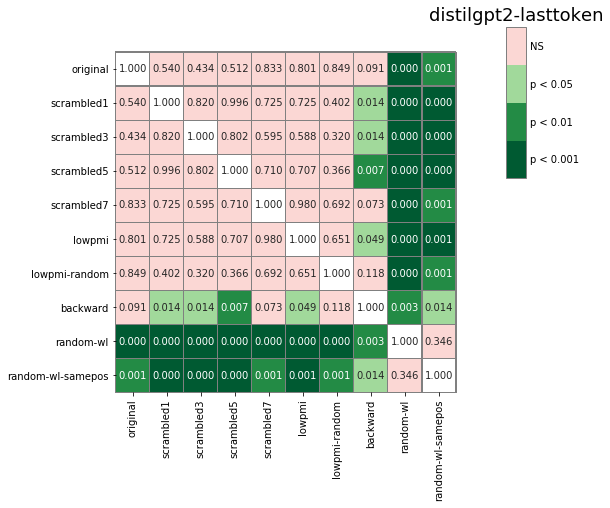

In [13]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="scrambled")

scrambled-backward
scrambled-lowpmi
scrambled-lowpmi-random
scrambled-original
scrambled-random-wl
scrambled-random-wl-samepos
scrambled1
scrambled3
scrambled5
                   original  scrambled1  scrambled3  scrambled5  lowpmi  \
original               -1.0         0.0         0.0         0.0     0.0   
scrambled1              0.0        -1.0         0.0         0.0     0.0   
scrambled3              0.0         0.0        -1.0         0.0     0.0   
scrambled5              0.0         0.0         0.0        -1.0     0.0   
lowpmi                  0.0         0.0         0.0         0.0    -1.0   
lowpmi-random           0.0         0.0         0.0         0.0     0.0   
backward                0.0         0.0         0.0         0.0     0.0   
random-wl               0.0         0.0         0.0         3.0     3.0   
random-wl-samepos       3.0         1.0         2.0         1.0     1.0   

                   lowpmi-random  backward  random-wl  random-wl-samepos  
original      

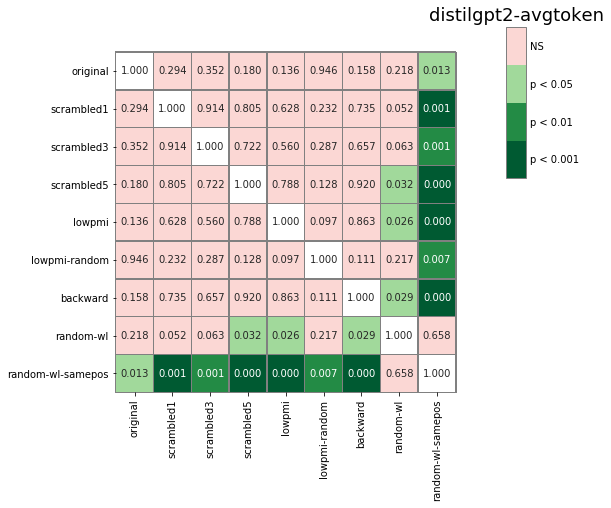

In [14]:
g=anova_ttest('distilgpt2-avgtoken',categories_dict,scr_perturb="scrambled")

perturb-contentwords
perturb-functionwords
perturb-nouns
perturb-nounsverbs
perturb-nounsverbsadj
perturb-random-nouns
perturb-sentenceshuffle_passage
perturb-sentenceshuffle_random
perturb-sentenceshuffle_random-topic-criteria
perturb-sentenceshuffle_random-topic-length-criteria
perturb-sentenceshuffle_topic
scrambled-original
                         original  nouns  nounsverbs  nounsverbsadj  \
original                     -1.0    0.0         0.0            0.0   
nouns                         0.0   -1.0         0.0            0.0   
nounsverbs                    0.0    0.0        -1.0            0.0   
nounsverbsadj                 0.0    0.0         0.0           -1.0   
contentwords                  0.0    0.0         0.0            0.0   
random-nouns                  1.0    3.0         3.0            2.0   
functionwords                 1.0    1.0         1.0            1.0   
sent_passage                  0.0    0.0         0.0            0.0   
sent_topic                    2

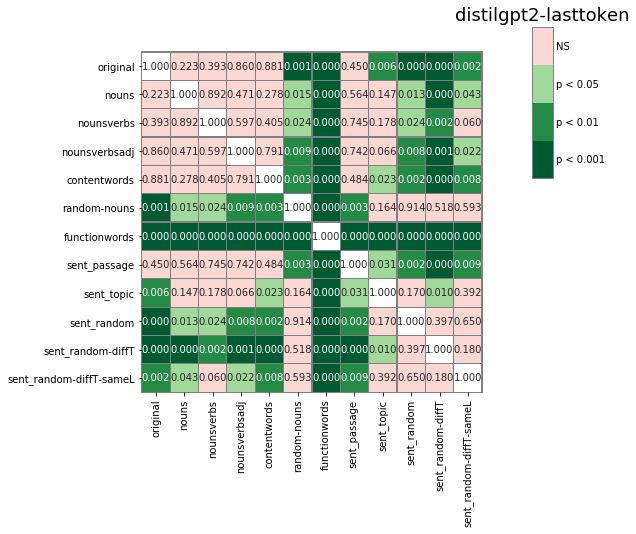

In [15]:
g=anova_ttest('distilgpt2',categories_dict,scr_perturb="perturb")

perturb-contentwords
perturb-functionwords
perturb-nouns
perturb-nounsverbs
perturb-nounsverbsadj
perturb-random-nouns
perturb-sentenceshuffle_passage
perturb-sentenceshuffle_random
perturb-sentenceshuffle_random-topic-criteria
perturb-sentenceshuffle_random-topic-length-criteria
perturb-sentenceshuffle_topic
scrambled-original
                         original  nouns  nounsverbs  nounsverbsadj  \
original                     -1.0    0.0         0.0            0.0   
nouns                         0.0   -1.0         0.0            0.0   
nounsverbs                    0.0    0.0        -1.0            0.0   
nounsverbsadj                 0.0    0.0         0.0           -1.0   
contentwords                  0.0    0.0         0.0            0.0   
random-nouns                  1.0    2.0         1.0            1.0   
functionwords                 1.0    1.0         1.0            1.0   
sent_passage                  0.0    0.0         0.0            0.0   
sent_topic                    3

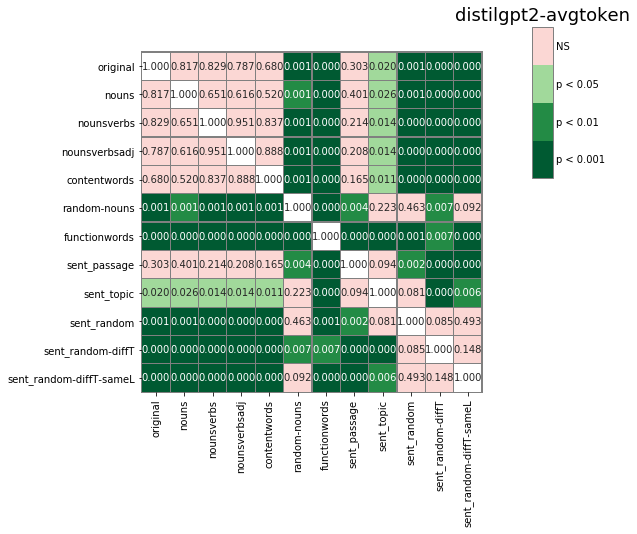

In [16]:
g=anova_ttest('distilgpt2-avgtoken',categories_dict,scr_perturb="perturb")

perturb-contentwords
perturb-functionwords
perturb-nouns
perturb-nounsverbs
perturb-nounsverbsadj
perturb-random-nouns
perturb-sentenceshuffle_passage
perturb-sentenceshuffle_random
perturb-sentenceshuffle_random-topic-criteria
perturb-sentenceshuffle_random-topic-length-criteria
perturb-sentenceshuffle_topic
scrambled-original
                         original  nouns  nounsverbs  nounsverbsadj  \
original                     -1.0    0.0         0.0            0.0   
nouns                         0.0   -1.0         0.0            0.0   
nounsverbs                    0.0    0.0        -1.0            0.0   
nounsverbsadj                 0.0    0.0         0.0           -1.0   
contentwords                  0.0    0.0         0.0            0.0   
random-nouns                  1.0    1.0         1.0            1.0   
functionwords                 1.0    1.0         1.0            1.0   
sent_passage                  0.0    0.0         0.0            0.0   
sent_topic                    2

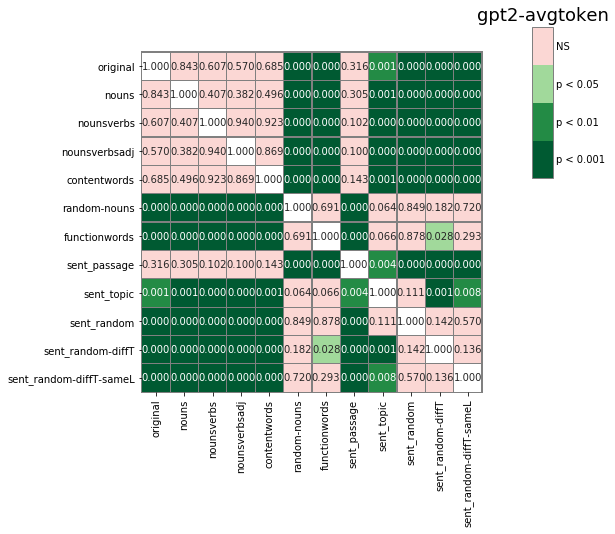

In [17]:
g=anova_ttest('gpt2-avgtoken',categories_dict,scr_perturb="perturb")

perturb-contentwords
perturb-functionwords
perturb-nouns
perturb-nounsverbs
perturb-nounsverbsadj
perturb-random-nouns
perturb-sentenceshuffle_passage
perturb-sentenceshuffle_random
perturb-sentenceshuffle_random-topic-criteria
perturb-sentenceshuffle_random-topic-length-criteria
perturb-sentenceshuffle_topic
scrambled-original
                         original  nouns  nounsverbs  nounsverbsadj  \
original                     -1.0    1.0         0.0            0.0   
nouns                         1.0   -1.0         3.0            3.0   
nounsverbs                    0.0    3.0        -1.0            0.0   
nounsverbsadj                 0.0    3.0         0.0           -1.0   
contentwords                  0.0    2.0         0.0            0.0   
random-nouns                  1.0    0.0         2.0            1.0   
functionwords                 1.0    1.0         1.0            1.0   
sent_passage                  0.0    3.0         0.0            0.0   
sent_topic                    1

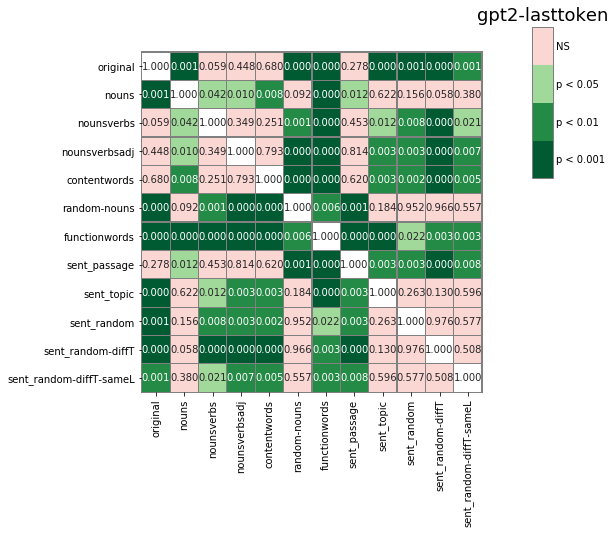

In [18]:
g=anova_ttest('gpt2',categories_dict,scr_perturb="perturb")

scrambled-backward
scrambled-lowpmi
scrambled-lowpmi-random
scrambled-original
scrambled-random-wl
scrambled-random-wl-samepos
scrambled1
scrambled3
scrambled5
scrambled7
                   original  scrambled1  scrambled3  scrambled5  scrambled7  \
original               -1.0         0.0         0.0         0.0         0.0   
scrambled1              0.0        -1.0         0.0         0.0         0.0   
scrambled3              0.0         0.0        -1.0         0.0         0.0   
scrambled5              0.0         0.0         0.0        -1.0         0.0   
scrambled7              0.0         0.0         0.0         0.0        -1.0   
lowpmi                  0.0         0.0         0.0         0.0         0.0   
lowpmi-random           0.0         0.0         0.0         0.0         0.0   
backward                0.0         0.0         0.0         0.0         0.0   
random-wl               2.0         2.0         2.0         2.0         1.0   
random-wl-samepos       2.0         2.0

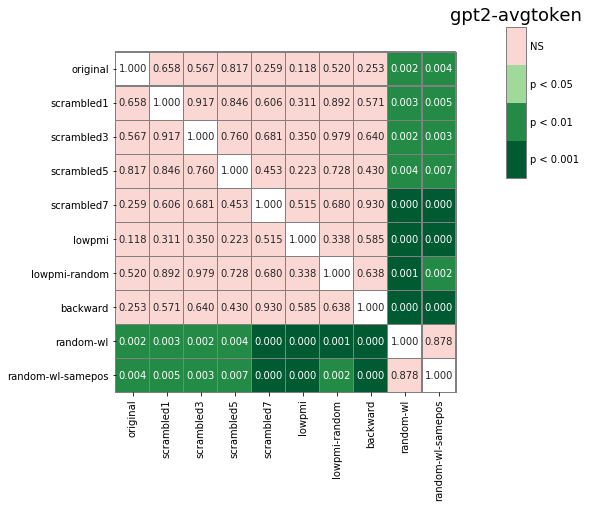

In [19]:
g=anova_ttest('gpt2-avgtoken',categories_dict,scr_perturb="scrambled")

scrambled-backward
scrambled-lowpmi
scrambled-lowpmi-random
scrambled-original
scrambled-random-wl
scrambled-random-wl-samepos
scrambled1
scrambled3
scrambled5
scrambled7
                   original  scrambled1  scrambled3  scrambled5  scrambled7  \
original               -1.0         0.0         0.0         0.0         0.0   
scrambled1              0.0        -1.0         0.0         0.0         0.0   
scrambled3              0.0         0.0        -1.0         0.0         0.0   
scrambled5              0.0         0.0         0.0        -1.0         0.0   
scrambled7              0.0         0.0         0.0         0.0        -1.0   
lowpmi                  0.0         0.0         0.0         0.0         0.0   
lowpmi-random           3.0         0.0         0.0         0.0         0.0   
backward                0.0         0.0         0.0         0.0         0.0   
random-wl               1.0         2.0         1.0         2.0         2.0   
random-wl-samepos       1.0         1.0

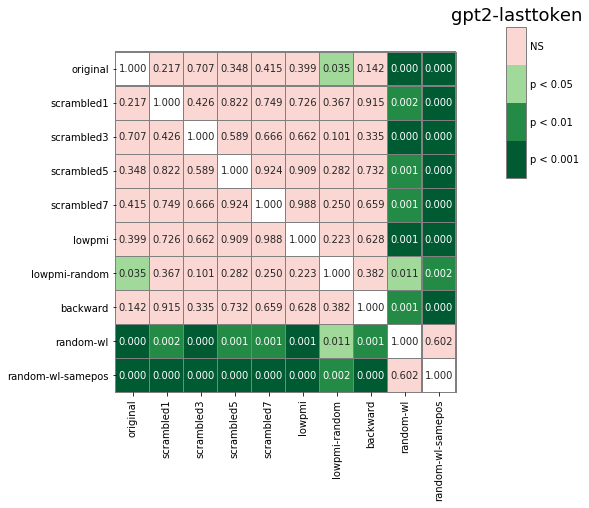

In [20]:
g=anova_ttest('gpt2',categories_dict,scr_perturb="scrambled")

# Loop into subplots

In [21]:
import math
from matplotlib.gridspec import GridSpec

def get_stats_loop(model_list,scr_perturb=None):
    nsubplots = len(model_list)
    nrows = math.ceil(nsubplots/2)
    
    #fig2 = plt.figure(constrained_layout=True, figsize=(12, 5.5*nrows))
    fig2 = plt.figure(constrained_layout=True, figsize=(18, 8*nrows))
    #fig2 = plt.figure(figsize=(20, 10*nrows))
    fig2.suptitle(f'Post-hoc ANOVA pairwise t-tests | {scr_perturb}', fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    model_counter = 0
    for i in range(nrows):
        for j in range(2):
            if model_counter + 1 > nsubplots:
                break
            else:
                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                scores, subdict, subdf = get_best_scores_df(model_list[model_counter],categories_dict,scr_perturb=scr_perturb)
    
#                 if scr_perturb == "scrambled":
#                     F, p = stats.f_oneway(subdict['original'], subdict['scrambled1'],
#                      subdict['scrambled3'], subdict['scrambled5'],
#                      subdict['scrambled7'], subdict['lowpmi'],
#                      subdict['lowpmi-random'], subdict['backward'],
#                      subdict['random-wl'], subdict['random-wl-samepos'])

#                 elif scr_perturb == "perturb":
#                     F, p = stats.f_oneway(subdict['original'],
#                     subdict['nouns'],subdict['random-nouns'],
#                     subdict['nounsverbs'], subdict['nounsverbsadj'],
#                     subdict['contentwords'], subdict['functionwords'],
#                     subdict['sentenceshuffle_random'], subdict['sentenceshuffle_random-topic-criteria'],
#                     subdict['sentenceshuffle_random-topic-length-criteria'], 
#                     subdict['sentenceshuffle_passage'], subdict['sentenceshuffle_topic'])


                # abbreviate condition names for perturb
                curr_groups = list(subdf["groups"])
                new_groups = []
                for elm in curr_groups:
                    if "sentenceshuffle_random" in elm:
                        elm = re.sub("sentenceshuffle_random","sent_random",elm)
                    if "topic-length-criteria" in elm:
                        elm = re.sub("topic-length-criteria","diffT-sameL",elm)
                    elif "topic-criteria" in elm:
                        elm = re.sub("topic-criteria","diffT",elm)
                    if elm == "sentenceshuffle_passage":
                        elm = re.sub("sentenceshuffle_passage","sent_passage",elm)
                    if elm == "sentenceshuffle_topic":
                        elm = re.sub("sentenceshuffle_topic","sent_topic",elm)
                    new_groups.append(elm)
                subdf["new_groups"] = new_groups
                
                if only_controlled_random:
                    subdf = subdf.drop(subdf[subdf.new_groups == "sent_random"].index)
                    subdf = subdf.drop(subdf[subdf.new_groups == "sent_random-diffT"].index)
    
                ttest = sp.posthoc_ttest(subdf, val_col='values', group_col='new_groups')#, p_adjust='fdr_bh')
                #f2_ax[-1].figure(figsize=(6,6))
                sp.sign_plot(ttest, annot=ttest, fmt='.3f', **heatmap_args)
                model_name = model_list[model_counter]
                if not "avgtoken" in model_name:
                    model_name += "-lasttoken"
                f2_ax[-1].set_title(f'{model_name}',fontsize=18, pad=15)
                model_counter += 1
    if save:
        fig2.savefig(f'fig/stats-match-to-brain_loop_{scr_perturb}.png', bbox_inches='tight')

perturb-contentwords
perturb-functionwords
perturb-nouns
perturb-nounsverbs
perturb-nounsverbsadj
perturb-random-nouns
perturb-sentenceshuffle_passage
perturb-sentenceshuffle_random
perturb-sentenceshuffle_random-topic-criteria
perturb-sentenceshuffle_random-topic-length-criteria
perturb-sentenceshuffle_topic
scrambled-original
                         original  nouns  nounsverbs  nounsverbsadj  \
original                     -1.0    0.0         0.0            0.0   
nouns                         0.0   -1.0         0.0            0.0   
nounsverbs                    0.0    0.0        -1.0            0.0   
nounsverbsadj                 0.0    0.0         0.0           -1.0   
contentwords                  0.0    0.0         0.0            0.0   
random-nouns                  1.0    3.0         3.0            2.0   
functionwords                 1.0    1.0         1.0            1.0   
sent_passage                  0.0    0.0         0.0            0.0   
sent_topic                    2

perturb-contentwords
perturb-functionwords
perturb-nouns
perturb-nounsverbs
perturb-nounsverbsadj
perturb-random-nouns
perturb-sentenceshuffle_passage
perturb-sentenceshuffle_random
perturb-sentenceshuffle_random-topic-criteria
perturb-sentenceshuffle_random-topic-length-criteria
perturb-sentenceshuffle_topic
scrambled-original
                         original  nouns  nounsverbs  nounsverbsadj  \
original                     -1.0    0.0         0.0            0.0   
nouns                         0.0   -1.0         0.0            0.0   
nounsverbs                    0.0    0.0        -1.0            0.0   
nounsverbsadj                 0.0    0.0         0.0           -1.0   
contentwords                  0.0    0.0         0.0            0.0   
random-nouns                  1.0    1.0         1.0            1.0   
functionwords                 1.0    1.0         1.0            1.0   
sent_passage                  0.0    0.0         0.0            0.0   
sent_topic                    2

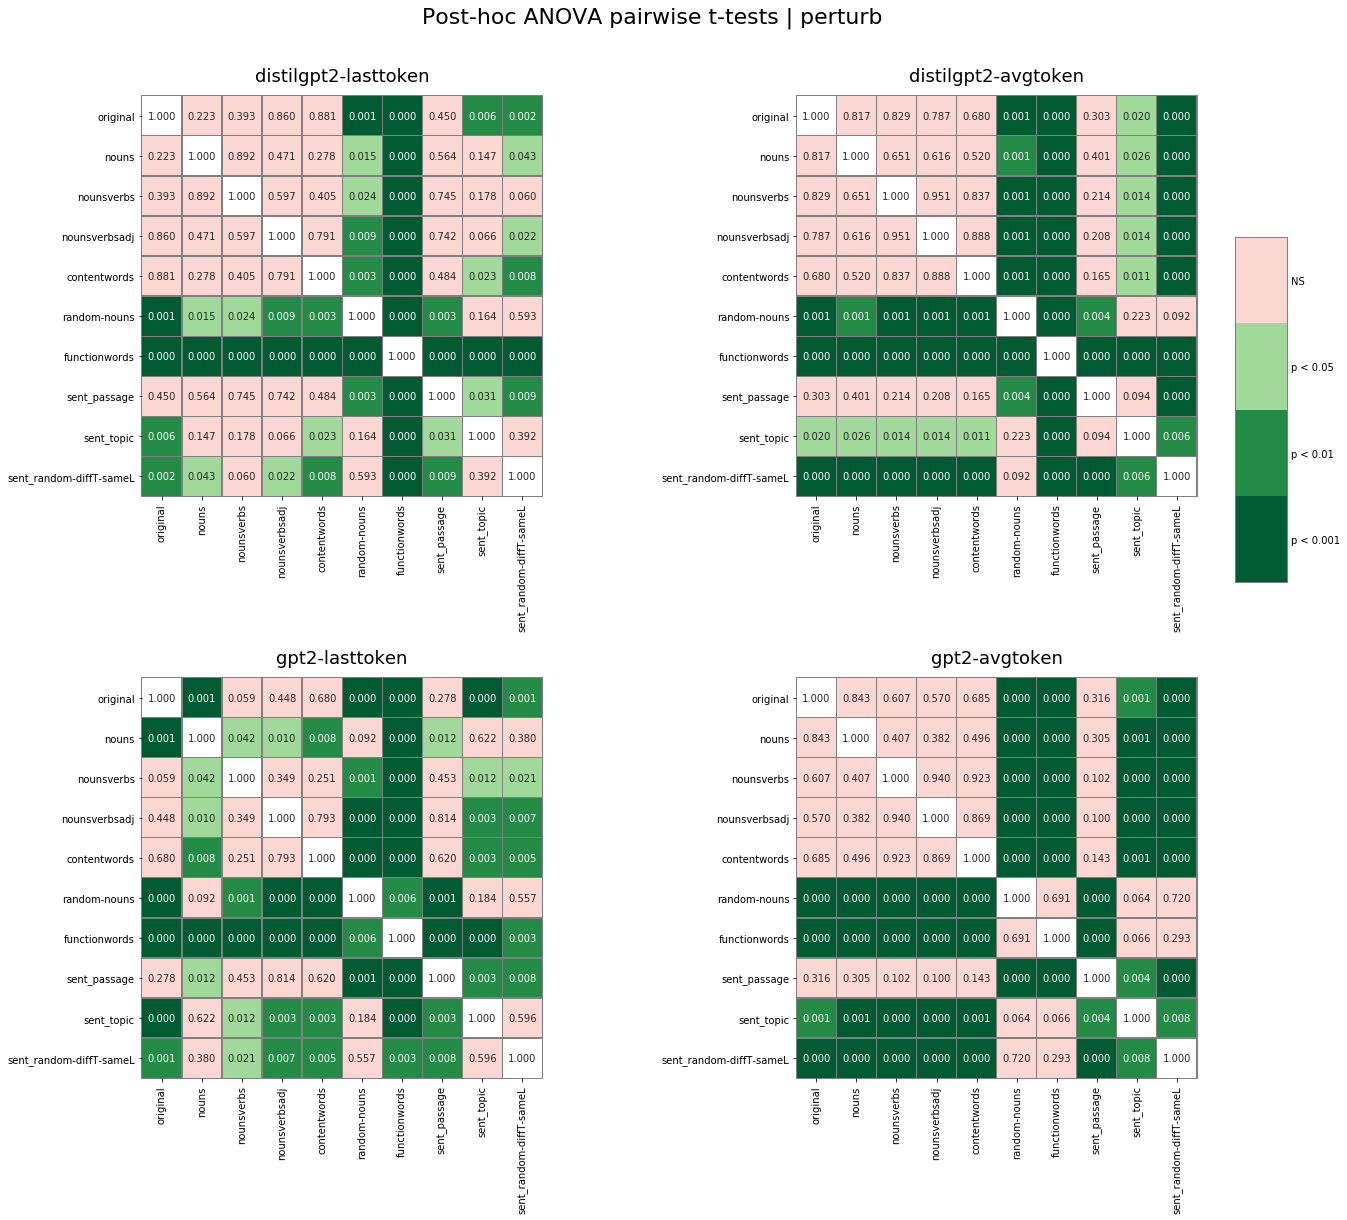

In [22]:
get_stats_loop(["distilgpt2", "distilgpt2-avgtoken", "gpt2", "gpt2-avgtoken"], scr_perturb="perturb")

scrambled-backward
scrambled-lowpmi
scrambled-lowpmi-random
scrambled-original
scrambled-random-wl
scrambled-random-wl-samepos
scrambled1
scrambled3
scrambled5
scrambled7
                   original  scrambled1  scrambled3  scrambled5  scrambled7  \
original               -1.0         0.0         0.0         0.0         0.0   
scrambled1              0.0        -1.0         0.0         0.0         0.0   
scrambled3              0.0         0.0        -1.0         0.0         0.0   
scrambled5              0.0         0.0         0.0        -1.0         0.0   
scrambled7              0.0         0.0         0.0         0.0        -1.0   
lowpmi                  0.0         0.0         0.0         0.0         0.0   
lowpmi-random           0.0         0.0         0.0         0.0         0.0   
backward                0.0         3.0         3.0         2.0         0.0   
random-wl               1.0         1.0         1.0         1.0         1.0   
random-wl-samepos       2.0         1.0

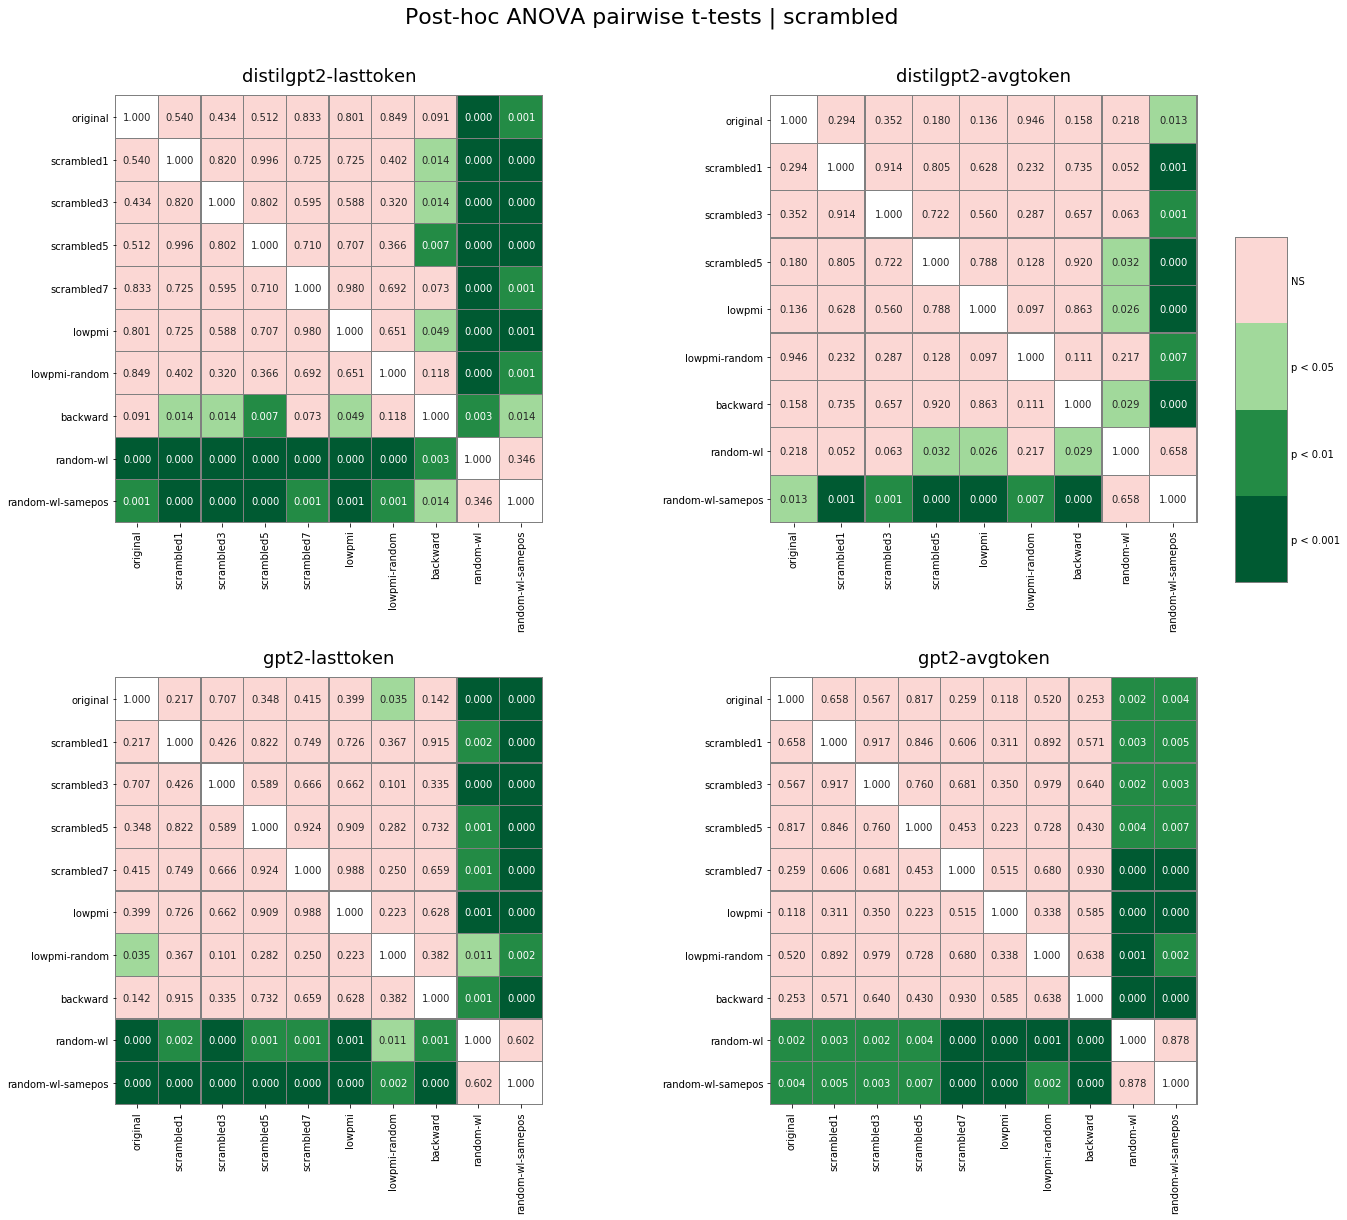

In [23]:
get_stats_loop(["distilgpt2", "distilgpt2-avgtoken", "gpt2", "gpt2-avgtoken"], scr_perturb="scrambled")